In [69]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
import sklearn
from sklearn.model_selection import KFold

import zipfile
import os

from helper_functions import *

import tensorflow as tf
import tensorflow_decision_forests as tfdf

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

## Preparing the Data

In [72]:
full_data = pd.read_csv('cook_county_train.csv')
full_data.drop(['PIN', 'Construction Quality', 'Site Desirability', 'Other Improvements', 'Deed No.',
                   'Sale Half of Year', 'Sale Quarter of Year', 'Description', 'Modeling Group', 'Unnamed: 0', 'Estimate (Land)', 
                'Estimate (Building)'
               ], axis=1, inplace=True)
train, valid = train_val_split(full_data)

train.columns = [
    col.replace(" ", "_")          # remove spaces
       .replace("(", "")           # remove parentheses
       .replace(")", "")
       .replace("-", "_")          # replace dashes with underscores
       .replace("/", "_")          # replace slashes with underscores
    for col in train.columns
]
valid.columns = [
    col.replace(" ", "_")          # remove spaces
       .replace("(", "")           # remove parentheses
       .replace(")", "")
       .replace("-", "_")          # replace dashes with underscores
       .replace("/", "_")          # replace slashes with underscores
    for col in valid.columns
]

X_train = train.drop('Sale_Price', axis = 1)
X_valid = valid.drop('Sale_Price', axis = 1)
y_train = train[['Sale_Price']]
y_valid = valid[['Sale_Price']]
valid_ds_final = tf.data.Dataset.from_tensor_slices((X_valid_final, y_valid_final)).batch(100)

## Selecting the Max Depth

In [49]:
max_depth_options = [10, 15, 20, None]
kf = KFold(n_splits = 5, shuffle = True, random_state = 7)
results = {}
models = {}
for max_depth in max_depth_options:
    print(f"\nTraining with max_depth = {max_depth}")
    fold_rmse = []
    fold = 1
    fold_models = []

    for train_index, valid_index in kf.split(X_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        train_ds = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold)).batch(100)
        valid_ds = tf.data.Dataset.from_tensor_slices((X_valid_fold, y_valid_fold)).batch(100)
        model = tfdf.keras.RandomForestModel(
            task=tfdf.keras.Task.REGRESSION,
            max_depth=max_depth,
            verbose=0
        )
    
        model.compile(metrics=["RootMeanSquaredError"])
    
        model.fit(train_ds, verbose=0)
    
        evaluation = model.evaluate(valid_ds, verbose=0)
        rmse = evaluation[1]
        print(f" Fold {fold} RMSE: {rmse: .2f}")
        fold_rmse.append(rmse)
        fold += 1
    avg_rmse = np.mean(fold_rmse)
    results[max_depth] = rmse
    models[max_depth] = fold_models
    print(f" Average RMSE for max_depth = {max_depth}: {avg_rmse:.2f}")

print("\nResults for each max_depth candidate:")
for depth, rmse in results.items():
    print(f"max_depth = {depth}: RMSE = {rmse:.4f}")


Training with max_depth = 10


I0000 00:00:1742886948.488951 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742886948.488973 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742886948.488978 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742886948.489108 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742886948.489113 1374968 kernel.cc:402] Number of examples: 131066
I0000 00:00:1742886948.572104 1374968 kernel.cc:802] Training dataset:
Number of records: 131066
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245467 min:1 max:7.1e+07 sd:384821
	1: "data:0.0" NUMERICAL mean:212.355 min:202 max:278 sd:24.09

 Fold 1 RMSE:  133882.05


I0000 00:00:1742886988.683087 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742886988.683104 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742886988.683108 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742886988.683239 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742886988.683245 1374968 kernel.cc:402] Number of examples: 131066
I0000 00:00:1742886988.766293 1374968 kernel.cc:802] Training dataset:
Number of records: 131066
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:244534 min:1 max:2.8e+07 sd:331393
	1: "data:0.0" NUMERICAL mean:212.327 min:202 max:278 sd:24.06

 Fold 2 RMSE:  414886.97


I0000 00:00:1742887032.489600 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742887032.489628 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742887032.489635 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742887032.489821 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742887032.489829 1374968 kernel.cc:402] Number of examples: 131066
I0000 00:00:1742887032.614519 1374968 kernel.cc:802] Training dataset:
Number of records: 131066
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245543 min:1 max:7.1e+07 sd:377073
	1: "data:0.0" NUMERICAL mean:212.334 min:202 max:278 sd:24.07

 Fold 3 RMSE:  212798.58


I0000 00:00:1742887079.223533 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742887079.223560 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742887079.223568 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742887079.223764 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742887079.223772 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742887079.361223 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245867 min:1 max:7.1e+07 sd:387455
	1: "data:0.0" NUMERICAL mean:212.309 min:202 max:278 sd:24.03

 Fold 4 RMSE:  121218.72


I0000 00:00:1742887126.959698 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742887126.959722 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742887126.959729 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742887126.959922 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742887126.959929 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742887127.084211 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245635 min:1 max:7.1e+07 sd:386035
	1: "data:0.0" NUMERICAL mean:212.294 min:202 max:278 sd:24.02

 Fold 5 RMSE:  137928.80
 Average RMSE for max_depth = 10: 204143.02

Training with max_depth = 15


I0000 00:00:1742887177.280211 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742887177.280229 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742887177.280235 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742887177.280375 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742887177.280381 1374968 kernel.cc:402] Number of examples: 131066
I0000 00:00:1742887177.393532 1374968 kernel.cc:802] Training dataset:
Number of records: 131066
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245467 min:1 max:7.1e+07 sd:384821
	1: "data:0.0" NUMERICAL mean:212.355 min:202 max:278 sd:24.09

 Fold 1 RMSE:  117149.84


I0000 00:00:1742887276.716977 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742887276.717004 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742887276.717013 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742887276.717240 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742887276.717249 1374968 kernel.cc:402] Number of examples: 131066
I0000 00:00:1742887276.845431 1374968 kernel.cc:802] Training dataset:
Number of records: 131066
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:244534 min:1 max:2.8e+07 sd:331393
	1: "data:0.0" NUMERICAL mean:212.327 min:202 max:278 sd:24.06

 Fold 2 RMSE:  410252.84


I0000 00:00:1742887370.637662 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742887370.637682 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742887370.637692 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742887370.637858 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742887370.637864 1374968 kernel.cc:402] Number of examples: 131066
I0000 00:00:1742887370.750391 1374968 kernel.cc:802] Training dataset:
Number of records: 131066
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245543 min:1 max:7.1e+07 sd:377073
	1: "data:0.0" NUMERICAL mean:212.334 min:202 max:278 sd:24.07

 Fold 3 RMSE:  204498.14


I0000 00:00:1742887476.233895 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742887476.233923 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742887476.233931 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742887476.234163 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742887476.234171 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742887476.358652 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245867 min:1 max:7.1e+07 sd:387455
	1: "data:0.0" NUMERICAL mean:212.309 min:202 max:278 sd:24.03

 Fold 4 RMSE:  105237.30


I0000 00:00:1742887566.432386 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742887566.432413 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742887566.432419 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742887566.432594 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742887566.432601 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742887566.544899 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245635 min:1 max:7.1e+07 sd:386035
	1: "data:0.0" NUMERICAL mean:212.294 min:202 max:278 sd:24.02

 Fold 5 RMSE:  121186.48
 Average RMSE for max_depth = 15: 191664.92

Training with max_depth = 20


I0000 00:00:1742887663.814688 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742887663.814716 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742887663.814724 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742887663.814944 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742887663.814952 1374968 kernel.cc:402] Number of examples: 131066
I0000 00:00:1742887663.934409 1374968 kernel.cc:802] Training dataset:
Number of records: 131066
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245467 min:1 max:7.1e+07 sd:384821
	1: "data:0.0" NUMERICAL mean:212.355 min:202 max:278 sd:24.09

 Fold 1 RMSE:  115849.63


I0000 00:00:1742887832.592005 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742887832.592050 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742887832.592067 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742887832.596763 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742887832.596786 1374968 kernel.cc:402] Number of examples: 131066
I0000 00:00:1742887832.661561 1374968 kernel.cc:802] Training dataset:
Number of records: 131066
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:244534 min:1 max:2.8e+07 sd:331393
	1: "data:0.0" NUMERICAL mean:212.327 min:202 max:278 sd:24.06

 Fold 2 RMSE:  409581.91


I0000 00:00:1742888005.693825 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742888005.693862 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742888005.693885 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742888005.697079 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742888005.697091 1374968 kernel.cc:402] Number of examples: 131066
I0000 00:00:1742888005.811186 1374968 kernel.cc:802] Training dataset:
Number of records: 131066
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245543 min:1 max:7.1e+07 sd:377073
	1: "data:0.0" NUMERICAL mean:212.334 min:202 max:278 sd:24.07

 Fold 3 RMSE:  203564.89


I0000 00:00:1742888345.679901 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742888345.680546 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742888345.680563 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742888345.683782 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742888345.683792 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742888345.779315 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245867 min:1 max:7.1e+07 sd:387455
	1: "data:0.0" NUMERICAL mean:212.309 min:202 max:278 sd:24.03

 Fold 4 RMSE:  102487.14


I0000 00:00:1742888498.280228 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742888498.280270 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742888498.280278 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742888498.283339 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742888498.283350 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742888498.400041 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245635 min:1 max:7.1e+07 sd:386035
	1: "data:0.0" NUMERICAL mean:212.294 min:202 max:278 sd:24.02

 Fold 5 RMSE:  119682.14
 Average RMSE for max_depth = 20: 190233.14

Training with max_depth = None


I0000 00:00:1742888690.579555 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742888690.580280 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742888690.580305 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742888690.584392 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742888690.584431 1374968 kernel.cc:402] Number of examples: 131066
I0000 00:00:1742888690.716391 1374968 kernel.cc:802] Training dataset:
Number of records: 131066
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245467 min:1 max:7.1e+07 sd:384821
	1: "data:0.0" NUMERICAL mean:212.355 min:202 max:278 sd:24.09

 Fold 1 RMSE:  115955.93


I0000 00:00:1742888823.111670 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742888823.111789 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742888823.111810 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742888823.114911 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742888823.114926 1374968 kernel.cc:402] Number of examples: 131066
I0000 00:00:1742888823.244018 1374968 kernel.cc:802] Training dataset:
Number of records: 131066
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:244534 min:1 max:2.8e+07 sd:331393
	1: "data:0.0" NUMERICAL mean:212.327 min:202 max:278 sd:24.06

 Fold 2 RMSE:  410062.47


I0000 00:00:1742888918.246096 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742888918.246119 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742888918.246123 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742888918.248919 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742888918.248926 1374968 kernel.cc:402] Number of examples: 131066
I0000 00:00:1742888918.332050 1374968 kernel.cc:802] Training dataset:
Number of records: 131066
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245543 min:1 max:7.1e+07 sd:377073
	1: "data:0.0" NUMERICAL mean:212.334 min:202 max:278 sd:24.07

 Fold 3 RMSE:  203964.81


I0000 00:00:1742889011.408256 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742889011.408285 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742889011.408294 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742889011.411654 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742889011.411669 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742889011.537767 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245867 min:1 max:7.1e+07 sd:387455
	1: "data:0.0" NUMERICAL mean:212.309 min:202 max:278 sd:24.03

 Fold 4 RMSE:  104374.98


I0000 00:00:1742889127.340784 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742889127.340848 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742889127.340857 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742889127.341080 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742889127.341089 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742889127.461185 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245635 min:1 max:7.1e+07 sd:386035
	1: "data:0.0" NUMERICAL mean:212.294 min:202 max:278 sd:24.02

 Fold 5 RMSE:  120597.37
 Average RMSE for max_depth = None: 190991.11

Results for each max_depth candidate:
max_depth = 10: RMSE = 137928.7969
max_depth = 15: RMSE = 121186.4766
max_depth = 20: RMSE = 119682.1406
max_depth = None: RMSE = 120597.3672


## Selecting the Number of Trees

In [93]:
num_trees_candidates = [5, 10, 25, 50]
kf = KFold(n_splits = 2, shuffle = True, random_state = 89)
results = {}
models = []
model_folds = {}

for num_trees in num_trees_candidates:
    print(f"\nTraining model with {num_trees} trees")
    fold_rmse = []
    fold = 1
    fold_models = []

    for train_index, valid_index in kf.split(X_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        model = tfdf.keras.RandomForestModel(
            num_trees=num_trees,
            task=tfdf.keras.Task.REGRESSION, 
            max_depth = 20,
            verbose=0
        )

        model.compile(metrics=["RootMeanSquaredError"])

        model.fit(train_ds, verbose=0)
    

        evaluation = model.evaluate(valid_ds, verbose=0)

        rmse = evaluation[1]
        print(f" Fold {fold} RMSE: {rmse: .2f}")
        fold_rmse.append(rmse)
        fold += 1
    avg_rmse = np.mean(fold_rmse)
    model_folds[max_depth] = fold_models
    results[num_trees] = rmse
    models.append(model)
    print(f"Validation RMSE with {num_trees} trees: {rmse:.4f}")

print("\nResults for different numbers of trees:")
for num_trees, rmse in results.items():
    print(f"{num_trees} trees: RMSE = {rmse:.4f}")


Training model with 5 trees


I0000 00:00:1742891975.870143 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742891975.870553 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742891975.870559 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742891975.873578 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742891975.873587 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742891975.958811 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245635 min:1 max:7.1e+07 sd:386035
	1: "data:0.0" NUMERICAL mean:212.294 min:202 max:278 sd:24.02

 Fold 1 RMSE:  157759.09


I0000 00:00:1742891979.025012 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742891979.025036 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742891979.025042 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742891979.025193 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742891979.025199 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742891979.108081 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245635 min:1 max:7.1e+07 sd:386035
	1: "data:0.0" NUMERICAL mean:212.294 min:202 max:278 sd:24.02

 Fold 2 RMSE:  157759.09
Validation RMSE with 5 trees: 157759.0938

Training model with 10 trees


I0000 00:00:1742891982.539702 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742891982.539724 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742891982.539729 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742891982.539858 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742891982.539863 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742891982.623001 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245635 min:1 max:7.1e+07 sd:386035
	1: "data:0.0" NUMERICAL mean:212.294 min:202 max:278 sd:24.02

 Fold 1 RMSE:  141046.08


I0000 00:00:1742891989.380406 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742891989.380423 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742891989.380428 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742891989.380551 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742891989.380555 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742891989.463727 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245635 min:1 max:7.1e+07 sd:386035
	1: "data:0.0" NUMERICAL mean:212.294 min:202 max:278 sd:24.02

 Fold 2 RMSE:  141046.08
Validation RMSE with 10 trees: 141046.0781

Training model with 25 trees


I0000 00:00:1742891995.843558 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742891995.843571 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742891995.843575 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742891995.843690 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742891995.843695 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742891995.927804 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245635 min:1 max:7.1e+07 sd:386035
	1: "data:0.0" NUMERICAL mean:212.294 min:202 max:278 sd:24.02

 Fold 1 RMSE:  117546.90


I0000 00:00:1742892008.191918 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742892008.191936 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742892008.191942 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742892008.192063 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742892008.192068 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742892008.274117 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245635 min:1 max:7.1e+07 sd:386035
	1: "data:0.0" NUMERICAL mean:212.294 min:202 max:278 sd:24.02

 Fold 2 RMSE:  117546.90
Validation RMSE with 25 trees: 117546.8984

Training model with 50 trees


I0000 00:00:1742892020.923598 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742892020.923613 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742892020.923619 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742892020.923742 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742892020.923746 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742892021.007017 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245635 min:1 max:7.1e+07 sd:386035
	1: "data:0.0" NUMERICAL mean:212.294 min:202 max:278 sd:24.02

 Fold 1 RMSE:  117589.90


I0000 00:00:1742892053.814678 1374968 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742892053.814704 1374968 kernel.cc:783] Collect training examples
I0000 00:00:1742892053.814714 1374968 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742892053.817809 1374968 kernel.cc:401] Number of batches: 1311
I0000 00:00:1742892053.817817 1374968 kernel.cc:402] Number of examples: 131067
I0000 00:00:1742892053.902762 1374968 kernel.cc:802] Training dataset:
Number of records: 131067
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "__LABEL" NUMERICAL mean:245635 min:1 max:7.1e+07 sd:386035
	1: "data:0.0" NUMERICAL mean:212.294 min:202 max:278 sd:24.02

 Fold 2 RMSE:  117589.90
Validation RMSE with 50 trees: 117589.8984

Results for different numbers of trees:
5 trees: RMSE = 157759.0938
10 trees: RMSE = 141046.0781
25 trees: RMSE = 117546.8984
50 trees: RMSE = 117589.8984


In [97]:
best_model = models[3]

In [99]:
tfdf.model_plotter.plot_model_in_colab(best_model, tree_idx = 0, max_depth = 3)

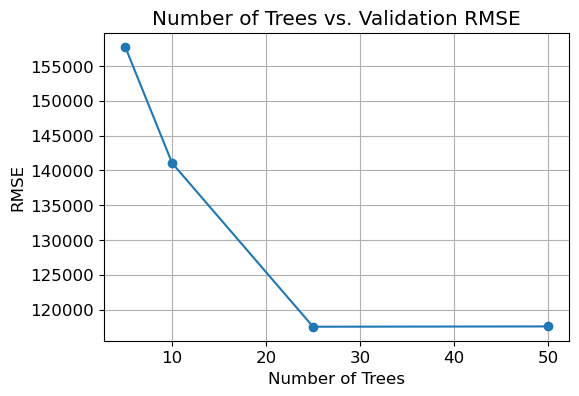

In [101]:
plt.figure(figsize=(6, 4))
num_trees_candidates = list(results.keys())
rmse_scores = list(results.values())
plt.plot(num_trees_candidates, rmse_scores, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.title("Number of Trees vs. Validation RMSE")
plt.grid(True)
plt.show()

In [102]:
inspector = best_model.make_inspector()

In [103]:
evaluation = best_model.evaluate(x=valid_ds_final,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.2f}")

410/410 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - root_mean_squared_error: 97093.8125
loss: 0.00
root_mean_squared_error: 97093.81


In [107]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES


In [109]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("data:0.26" (1; #20), 21.0),
 ("data:0.12" (1; #5), 12.0),
 ("data:0.0" (1; #1), 7.0),
 ("data:0.44" (1; #40), 4.0),
 ("data:0.45" (1; #41), 3.0),
 ("data:0.11" (1; #4), 1.0),
 ("data:0.32" (1; #27), 1.0),
 ("data:0.34" (1; #29), 1.0)]

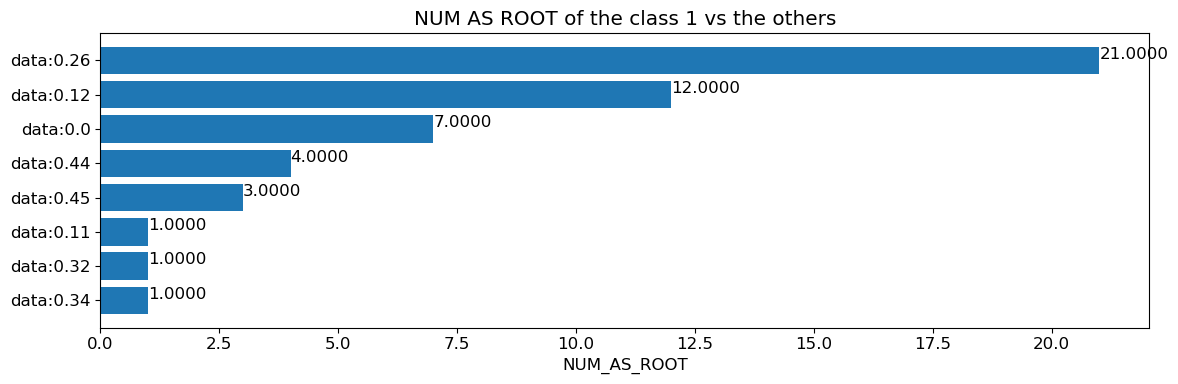

In [111]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()